<p><img alt="Colaboratory logo" height="45px" src="/img/colab_favicon.ico" align="left" hspace="10px" vspace="0px"></p>

#<h1>Import packages</h1>

In [ ]:
import easydict
import os
import numpy as np
import math
import matplotlib.pyplot as plt
 
import torchvision.transforms as transforms
from torchvision.utils import save_image
 
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.autograd import Variable
 
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision
 
import pandas as pd
from tqdm import tqdm 
import time
 
from random import randint
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
from IPython.display import HTML
from matplotlib import rc
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA

from scipy.interpolate import interp1d

%matplotlib inline
 
import copy as cp
from IPython.display import clear_output
 
os.makedirs("images", exist_ok=True)
arg = easydict.EasyDict({ "n_epochs": 15000, 
                          "batch_size": 256, 
                          "lr": 1e-3, 
                          "b1": 0.9,
                          "b2": 0.999,
                          "weight_decay": 0.0001,
                          "input_dim": 40,
                          "output_dim": 40,
                          "hidden_dim": [128,40],
                          "goal_dim": 6,
                          "n_cpu": 8,
                          "re_size": 64,
                          "z_dim": 128,
                          "sample_interval": 400 })
print(arg)
 
dt=2
cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

use_cuda = True
if torch.cuda.is_available():
  device = torch.device("cuda")

  

{'n_epochs': 15000, 'batch_size': 256, 'lr': 0.001, 'b1': 0.9, 'b2': 0.999, 'weight_decay': 0.0001, 'input_dim': 40, 'output_dim': 40, 'hidden_dim': [128, 40], 'goal_dim': 6, 'n_cpu': 8, 're_size': 64, 'z_dim': 128, 'sample_interval': 400}


<p><img alt="Colaboratory logo" height="45px" src="/img/colab_favicon.ico" align="left" hspace="10px" vspace="0px"></p>

#<h1>Data organization</h1>

In [ ]:
# Load data
TESTterrain = torch.tensor(np.load('/content/drive/MyDrive/Colab Notebooks/data/Terrain_XYZ_tensor.npy'))#[:-6000]
TESTterrain[-5999:] = 0.4 + TESTterrain[-5999:] 

# Place Path data into dataloader
class GenDataset(Dataset):
 
  def __init__(self, TerrainData, transform=None):
      self.data = TerrainData.float()
      self.transform = transform
      
  def __getitem__(self, index):
      data = self.data[index]
      if self.transform:
            data = self.transform(data)
      return index, data
 
  def __len__(self):
      return len(self.data)
 
transform = transforms.Compose(
    [
     transforms.ToPILImage(),
    #  transforms.Resize((arg.re_size, arg.re_size)),
     transforms.ToTensor(),
    ])
 
DeepQMPdataset = GenDataset(TESTterrain, transform=transform)
DeepQMPdata_loader = DataLoader(DeepQMPdataset,batch_size=arg.batch_size,shuffle=False)

def show(img,nrow=3):
  img_grid = torchvision.utils.make_grid(img,nrow=nrow).numpy()
  plt.figure()
  plt.imshow(np.transpose(img_grid, (1,2,0)))
  plt.axis('on')
  plt.show()

_, img = next(iter(DeepQMPdata_loader))
show(img[-9:,2].view(-1,1,100,100),nrow=3)

# np.save('/content/drive/MyDrive/Colab Notebooks/data/Terrain64x64', img)

# del TESTterrain

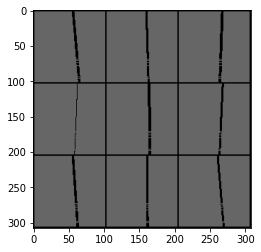

In [ ]:
tdata_loader = DataLoader(DeepQMPdataset,batch_size=len(DeepQMPdataset),shuffle=False)

_, img = next(iter(tdata_loader))
show(img[-9:,2].view(-1,1,100,100),nrow=3)

tensor(0.)
tensor(0.4000)


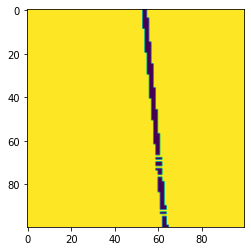

In [ ]:
test=TESTterrain[-5999:,2]
print(test.min())
print(test.max())
plt.imshow(test[0].view(100,100))

[링크 텍스트](https://)<p><img alt="Colaboratory logo" height="45px" src="/img/colab_favicon.ico" align="left" hspace="10px" vspace="0px"></p>

#<h1>Generate test terrain</h1>

In [ ]:
dataFlat = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/02.Terrain_data_test.txt')
dataFlat

,PathNum,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300
0,1,-4.9,-4.9,0,-4.8,-4.9,0,-4.7,-4.9,0,-4.6,-4.9,0,-4.5,-4.9,0,-4.4,-4.9,0,-4.3,-4.9,0,-4.2,-4.9,0,-4.1,-4.9,0,-4,-4.9,0,-3.9,-4.9,0,-3.8,-4.9,0,-3.7,-4.9,0,...,0.0,3.7,-4.9,0.0,3.8,-4.9,0.0,3.9,-4.9,0.0,4,-4.9,0.0,4.2,-4.9,0.0,0,0,0,4.4,-4.9,0,0,0,0,4.6,-4.9,0,4.7,-4.9,0,4.8,-4.9,0,4.9,-4.9,0,5,-4.9,0
1,1,-4.9,-4.8,0,-4.8,-4.8,0,-4.7,-4.8,0,-4.6,-4.8,0,-4.5,-4.8,0,-4.4,-4.8,0,-4.3,-4.8,0,-4.2,-4.8,0,-4.1,-4.8,0,-4,-4.8,0,-3.9,-4.8,0,-3.8,-4.8,0,-3.7,-4.8,0,...,0.0,3.7,-4.8,0.0,3.8,-4.8,0.0,3.9,-4.8,0.0,4,-4.8,0.0,4.2,-4.8,0.0,0,0,0,4.4,-4.8,0,0,0,0,4.6,-4.8,0,4.7,-4.8,0,4.8,-4.8,0,4.9,-4.8,0,5,-4.8,0
2,1,-4.9,-4.7,0,-4.8,-4.7,0,-4.7,-4.7,0,-4.6,-4.7,0,-4.5,-4.7,0,-4.4,-4.7,0,-4.3,-4.7,0,-4.2,-4.7,0,-4.1,-4.7,0,-4,-4.7,0,-3.9,-4.7,0,-3.8,-4.7,0,-3.7,-4.7,0,...,0.0,3.7,-4.7,0.0,3.8,-4.7,0.0,3.9,-4.7,0.0,4,-4.7,0.0,4.2,-4.7,0.0,0,0,0,4.4,-4.7,0,0,0,0,4.6,-4.7,0,4.7,-4.7,0,4.8,-4.7,0,4.9,-4.7,0,5,-4.7,0
3,1,-4.9,-4.6,0,-4.8,-4.6,0,-4.7,-4.6,0,-4.6,-4.6,0,-4.5,-4.6,0,-4.4,-4.6,0,-4.3,-4.6,0,-4.2,-4.6,0,-4.1,-4.6,0,-4,-4.6,0,-3.9,-4.6,0,-3.8,-4.6,0,-3.7,-4.6,0,...,0.0,3.7,-4.6,0.0,3.8,-4.6,0.0,3.9,-4.6,0.0,4,-4.6,0.0,4.2,-4.6,0.0,0,0,0,4.4,-4.6,0,0,0,0,4.6,-4.6,0,4.7,-4.6,0,4.8,-4.6,0,4.9,-4.6,0,5,-4.6,0
4,1,-4.9,-4.5,0,-4.8,-4.5,0,-4.7,-4.5,0,-4.6,-4.5,0,-4.5,-4.5,0,-4.4,-4.5,0,-4.3,-4.5,0,-4.2,-4.5,0,-4.1,-4.5,0,-4,-4.5,0,-3.9,-4.5,0,-3.8,-4.5,0,-3.7,-4.5,0,...,0.0,3.7,-4.5,0.0,3.8,-4.5,0.0,3.9,-4.5,0.0,4,-4.5,0.0,4.2,-4.5,0.0,0,0,0,4.4,-4.5,0,0,0,0,4.6,-4.5,0,4.7,-4.5,0,4.8,-4.5,0,4.9,-4.5,0,5,-4.5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1,-4.9,4.6,0,-4.8,4.6,0,-4.7,4.6,0,-4.6,4.6,0,-4.5,4.6,0,-4.4,4.6,0,-4.3,4.6,0,-4.2,4.6,0,-4.1,4.6,0,-4,4.6,0,-3.9,4.6,0,-3.8,4.6,0,-3.7,4.6,0,...,0.2,3.7,4.6,0.2,3.8,4.6,0.2,3.9,4.6,0.2,4,4.6,0.2,4.2,4.6,0.0,0,0,0,4.4,4.6,0,0,0,0,4.6,4.6,0,4.7,4.6,0,4.8,4.6,0,4.9,4.6,0,5,4.6,0
96,1,-4.9,4.7,0,-4.8,4.7,0,-4.7,4.7,0,-4.6,4.7,0,-4.5,4.7,0,-4.4,4.7,0,-4.3,4.7,0,-4.2,4.7,0,-4.1,4.7,0,-4,4.7,0,-3.9,4.7,0,-3.8,4.7,0,-3.7,4.7,0,...,0.2,3.7,4.7,0.2,3.8,4.7,0.2,3.9,4.7,0.2,4,4.7,0.2,4.2,4.7,0.0,0,0,0,4.4,4.7,0,0,0,0,4.6,4.7,0,4.7,4.7,0,4.8,4.7,0,4.9,4.7,0,5,4.7,0
97,1,-4.9,4.8,0,-4.8,4.8,0,-4.7,4.8,0,-4.6,4.8,0,-4.5,4.8,0,-4.4,4.8,0,-4.3,4.8,0,-4.2,4.8,0,-4.1,4.8,0,-4,4.8,0,-3.9,4.8,0,-3.8,4.8,0,-3.7,4.8,0,...,0.2,3.7,4.8,0.2,3.8,4.8,0.2,3.9,4.8,0.2,4,4.8,0.2,4.2,4.8,0.0,0,0,0,4.4,4.8,0,0,0,0,4.6,4.8,0,4.7,4.8,0,4.8,4.8,0,4.9,4.8,0,5,4.8,0
98,1,-4.9,4.9,0,-4.8,4.9,0,-4.7,4.9,0,-4.6,4.9,0,-4.5,4.9,0,-4.4,4.9,0,-4.3,4.9,0,-4.2,4.9,0,-4.1,4.9,0,-4,4.9,0,-3.9,4.9,0,-3.8,4.9,0,-3.7,4.9,0,...,0.2,3.7,4.9,0.2,3.8,4.9,0.2,3.9,4.9,0.2,4,4.9,0.2,4.2,4.9,0.2,0,0,0,4.4,4.9,0,0,0,0,4.6,4.9,0,4.7,4.9,0,4.8,4.9,0,4.9,4.9,0,5,4.9,0


1


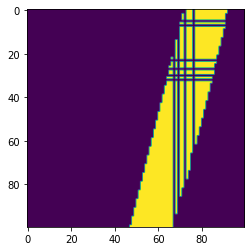

In [ ]:
CommonXY = np.mgrid[-5:5:0.1, -5:5:0.1]
FlatTerrainXYZ  = dataFlat.values[:,1:].reshape(-1,100,100,3);  Terrain_data_Flat = np.transpose(FlatTerrainXYZ, (0,3,1,2))
Terrain_data_Flat[:,0]=CommonXY[1]; Terrain_data_Flat[:,1]=CommonXY[0]
idx=randint(0,Terrain_data_Flat.shape[0])
print(idx)
tmp=torch.tensor(Terrain_data_Flat, dtype=float)
temp = torch.flip(tmp, dims=(2,))
plt.imshow(temp[-1,2].view(100,100))
plt.show()

In [ ]:
np.save('/content/drive/MyDrive/Colab Notebooks/data/nonflat', torch.tensor(Terrain_data_Flat[-1], dtype=float))